In [1]:
# import the necessary packages
from pyimagesearch.livenessnet import LivenessNet
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import cv2
import os
import matplotlib

In [ ]:
import os
import numpy as np
import shutil

# # Creating Train / Val / Test folders (One time use)
root_dir = 'dataset'
posCls = '/real'
negCls = '/fake'

# os.makedirs(root_dir +'/train' + posCls)
# os.makedirs(root_dir +'/train' + negCls)
# os.makedirs(root_dir +'/val' + posCls)
# os.makedirs(root_dir +'/val' + negCls)
# os.makedirs(root_dir +'/test' + posCls)
# os.makedirs(root_dir +'/test' + negCls)

# Creating partitions of the data after shuffeling
currentCls = negCls
src = "dataset"+currentCls # Folder to copy images from

allFileNames = os.listdir(src)
np.random.shuffle(allFileNames)
train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)*0.7), int(len(allFileNames)*0.85)])


train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
# test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

print('Total images: ', len(allFileNames))
print('Training: ', len(train_FileNames))
print('Validation: ', len(val_FileNames))
# print('Testing: ', len(test_FileNames))

# Copy-pasting images
for name in train_FileNames:
    shutil.copy(name, "dataset/train"+currentCls)

for name in val_FileNames:
    shutil.copy(name, "dataset/val"+currentCls)

In [2]:
# initialize the initial learning rate, batch size, and number of
# epochs to train for
INIT_LR = 1e-4
BS = 16
EPOCHS = 50

In [3]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images("dataset"))
data = []
labels = []

[INFO] loading images...


In [4]:
# loop over all image paths
for imagePath in imagePaths:
	# extract the class label from the filename, load the image and
	# resize it to be a fixed 32x32 pixels, ignoring aspect ratio
	label = imagePath.split(os.path.sep)[-2]
	image = cv2.imread(imagePath)
	image = cv2.resize(image, (224, 224))

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

In [5]:
import pandas
from collections import Counter
label_count = Counter(labels)


In [6]:
label_count

Counter({'fake': 2438, 'real': 864})

In [7]:
# convert the data into a NumPy array, then preprocess it by scaling
# all pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0

In [8]:
# encode the labels (which are currently strings) as integers and then
# one-hot encode them
le = LabelEncoder()
labels = le.fit_transform(labels)
labels = to_categorical(labels, 2)

In [9]:
np.unique(labels)

array([0., 1.], dtype=float32)

In [ ]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'data/val',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary')

In [10]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, random_state=42)

In [11]:
len(testX)

661

In [12]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
	width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
	horizontal_flip=True, fill_mode="nearest")

In [13]:
from keras.losses import categorical_crossentropy

In [14]:
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model = LivenessNet.build(width=224, height=224, depth=3,
    classes=2)
# opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss=categorical_crossentropy, metrics=['accuracy'])
# model.compile(loss="binary_crossentropy", optimizer=opt,
#     metrics=["accuracy"])

[INFO] compiling model...


In [ ]:
model.fit_generator(
        train_generator,
        steps_per_epoch=16 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=16 // batch_size)
model.save_weights('first_try.h5')  # always save your weights after training or during training

In [15]:
from keras.optimizers import Adam
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss=categorical_crossentropy, metrics=['accuracy'])

In [17]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
# hist = model.fit_generator(steps_per_epoch=100,generator=train_generator, validation_data= validation_generator, validation_steps=10,epochs=50,callbacks=[checkpoint,early])

In [18]:
# train the network
print("[INFO] training network for {} epochs...".format(EPOCHS))
H = model.fit(x=aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS,callbacks=[checkpoint,early])

[INFO] training network for 50 epochs...
Epoch 1/50
165/165 [==============================] - 50s 303ms/step - loss: 0.6092 - accuracy: 0.7303 - val_loss: 0.5666 - val_accuracy: 0.7474
Epoch 2/50
165/165 [==============================] - 46s 282ms/step - loss: 0.5824 - accuracy: 0.7356 - val_loss: 0.5688 - val_accuracy: 0.7474
Epoch 3/50
165/165 [==============================] - 47s 283ms/step - loss: 0.5808 - accuracy: 0.7371 - val_loss: 0.5704 - val_accuracy: 0.7474
Epoch 4/50
165/165 [==============================] - 47s 283ms/step - loss: 0.5802 - accuracy: 0.7360 - val_loss: 0.5675 - val_accuracy: 0.7474
Epoch 5/50
165/165 [==============================] - 47s 283ms/step - loss: 0.5795 - accuracy: 0.7371 - val_loss: 0.5656 - val_accuracy: 0.7474
Epoch 6/50
165/165 [==============================] - 47s 283ms/step - loss: 0.5812 - accuracy: 0.7356 - val_loss: 0.5694 - val_accuracy: 0.7474
Epoch 7/50
165/165 [==============================] - 47s 284ms/step - loss: 0.5832 - acc

Epoch 19/50
165/165 [==============================] - 47s 284ms/step - loss: 0.5780 - accuracy: 0.7352 - val_loss: 0.5653 - val_accuracy: 0.7474
Epoch 20/50
165/165 [==============================] - 47s 284ms/step - loss: 0.5802 - accuracy: 0.7349 - val_loss: 0.5653 - val_accuracy: 0.7474
Epoch 21/50
165/165 [==============================] - 47s 284ms/step - loss: 0.5800 - accuracy: 0.7360 - val_loss: 0.5653 - val_accuracy: 0.7474
Epoch 22/50
165/165 [==============================] - 47s 284ms/step - loss: 0.5778 - accuracy: 0.7368 - val_loss: 0.5653 - val_accuracy: 0.7474
Epoch 23/50
165/165 [==============================] - 47s 284ms/step - loss: 0.5795 - accuracy: 0.7356 - val_loss: 0.5652 - val_accuracy: 0.7474
Epoch 24/50
165/165 [==============================] - 47s 284ms/step - loss: 0.5785 - accuracy: 0.7356 - val_loss: 0.5652 - val_accuracy: 0.7474
Epoch 25/50
165/165 [==============================] - 47s 284ms/step - loss: 0.5793 - accuracy: 0.7356 - val_loss: 0.5653 -

Epoch 37/50
165/165 [==============================] - 47s 285ms/step - loss: 0.5784 - accuracy: 0.7368 - val_loss: 0.5658 - val_accuracy: 0.7474
Epoch 38/50
165/165 [==============================] - 47s 284ms/step - loss: 0.5778 - accuracy: 0.7356 - val_loss: 0.5677 - val_accuracy: 0.7474
Epoch 39/50
165/165 [==============================] - 47s 284ms/step - loss: 0.5778 - accuracy: 0.7371 - val_loss: 0.5660 - val_accuracy: 0.7474
Epoch 40/50
165/165 [==============================] - 47s 284ms/step - loss: 0.5805 - accuracy: 0.7356 - val_loss: 0.5658 - val_accuracy: 0.7474
Epoch 41/50
165/165 [==============================] - 47s 284ms/step - loss: 0.5788 - accuracy: 0.7360 - val_loss: 0.5677 - val_accuracy: 0.7474
Epoch 42/50
165/165 [==============================] - 47s 284ms/step - loss: 0.5772 - accuracy: 0.7371 - val_loss: 0.5675 - val_accuracy: 0.7474
Epoch 43/50
165/165 [==============================] - 47s 284ms/step - loss: 0.5794 - accuracy: 0.7356 - val_loss: 0.5673 -

In [19]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(x=testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=le.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

        fake       0.75      1.00      0.86       494
        real       0.00      0.00      0.00       167

    accuracy                           0.75       661
   macro avg       0.37      0.50      0.43       661
weighted avg       0.56      0.75      0.64       661



D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
# save the network to disk
print("[INFO] serializing network to '{}'...".format("liveness.model"))
model.save("liveness_vgg19.model", save_format="h5")

[INFO] serializing network to 'liveness.model'...


In [21]:
# save the label encoder to disk
f = open("le.pickle", "wb")
f.write(pickle.dumps(le))
f.close()

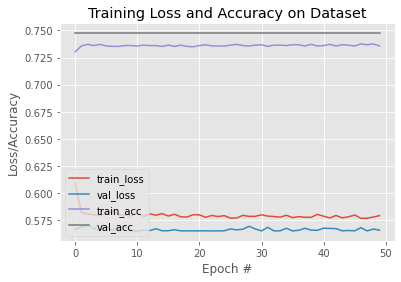

In [22]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot19.png")